# Emoji Prediction

In [247]:
import os
import csv
%pip install opencv-python-headless
import cv2
import numpy as np
from pprint import pprint

from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from collections import defaultdict

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.metrics import classification_report

import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from skimage import exposure

Note: you may need to restart the kernel to use updated packages.


## Render emoji by PIL
Convert text emoji to gray picture. You can download the font file of `NotoEmoji.ttf` from [here](https://fonts.google.com/noto/specimen/Noto+Emoji).

**Replace `your/path/to/NotoEmoji.ttf` with the path to the downloaded `.ttf` file on your machine.**

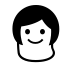

In [85]:
emoji = '👩‍⚕️'
size  = 64
image = Image.new("L", (64,64), (255))
font = ImageFont.truetype("NotoEmoji-VariableFont_wght.ttf", int(size * 0.9), encoding='unic')
draw = ImageDraw.Draw(image)
draw.textbbox(xy=[0,0], text=emoji, font=font)
draw.text((0, 0), emoji, fill=(0), font=font)
image

**Replace `your/path/to/NotoEmoji.ttf` with the path to the downloaded `.ttf` file on your machine.**

In [162]:
def emoji_to_image(emoji: str, size: int = 64) -> np.ndarray:
    image = Image.new("L", (64,64), (255))
    font = ImageFont.truetype("NotoEmoji-VariableFont_wght.ttf", 60, encoding='unic')
    draw = ImageDraw.Draw(image)
    draw.textbbox(xy=[0,0], text=emoji, font=font)
    draw.text((0, 0), emoji, fill=(0), font=font)
    return np.array(image)

### Pre-process Emoji data for training SVM

### Feature Extractio ###


In [329]:
sift = cv2.SIFT_create()

def gray_histogram(img: np.array, norm: bool = True) -> np.array:
    if img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hist = np.array([len(img[img == i]) for i in range(256)])
    if norm:
        return hist / np.size(img)
    return hist


def sift_feat(img):
    kps, des =  sift.detectAndCompute(img, None)
    des = des[:30] if des.shape[0] > 30 else np.pad(des, ((0, 30 - des.shape[0]), (0, 0)), 'constant')
    return des.flatten()


def lbp_feat(img, P=24, R=3, method="uniform"):
    """
    calculate the LBP
    
    - img: gray image
    - P: The number of points used for sampling in the LBP operator.
    - R: The radius of the LBP operator.

    - hist: Normalized LBP.
    """
    # use the LBP
    lbp = local_binary_pattern(img, P, R, method)
    
    # For uniform patterns, the maximum number of patterns is P * (P - 1) + 3
    bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins), density=True)
    
    return hist    

def hog_feat(img):
    """
    calculate the HOG
    """
    hog_feat = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, feature_vector=True)
    return hog_feat




def combined_feat(img):
    """
    combine method -> use HOG and LBP
    """
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    lbp_features  = lbp_feat(img)
    hog_features  = hog_feat(img)

    # combine
    combined_feat = np.hstack((lbp_features, hog_features))
    return combined_feat




def L2_distance(x, y):
    return ((x - y) ** 2).sum() ** 0.5

def L2_distance_sift(x, y):
    dist = ((x[:, None] - y[None, :])**2).sum(axis=-1).min(axis=-1)
    dist.sort()
    return dist[:15].mean()

def calc_distance(x, y):
    return L2_distance(x, y)
#   return L2_distance_sift(x, y)


def get_feat(img):
    # Check if the image has 3 channels (color image)
    if len(img.shape) == 3:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    else:
        gray_img = img



    """

    the following is the collection of all feature methods:
    HOG;
    Combined;
    Gray;
    SIFT;
    LBP

    """
    return hog_feat(gray_img)
    #return combined_feat(img)
    #return gray_histogram(img)
    #return sift_feat(img)
    #return lbp_histogram(gray_img)





In [330]:
# Define emojis and their labels.
emojis = ['😀', '😃', '😄', '😁', '😆','🙂','😊','😉', '😇',
          '🥰', '😍', '🤩', '😘', '😚',
          '😋', '😛', '😜', '🤪', '😝',
          '🤗', '🤭', '🫢', '🫣', '🤫','🤔','🫡',
          '🙃', '🫠', '🤐', '🤨', '😐','😑','🫥','😶‍🌫️',
          '😒', '🙄', '😬', '😮‍💨', '🤥','🤥','🫨',
          '😌', '😔', '😪', '😴',
          '😷', '🤒', '🤕', '🤢', '🤮','🤧','😵','😵‍💫',
          '🤬', '😡', '😠', '😭', '😣',
          '😈', '👿', '🤡', '👻', '👽','🤖','👾',
          '❤️', '💓', '💕', '💗', '💟',
          '🧑‍⚕️', '👨‍⚕️', '👩‍⚕️',
          '👮', '👮‍♂️', '👮‍♂️',
          '🐕', '🐩', '🦮', '🐕‍🦺',
          '🦃', '🦆', '🐓', '🦜', '🦢', '🐦',
          '😺','😸','😹','😻','😼','😽','🙀','😾',
          '⌚','⏰','⏱️','⏲️','🕰️','🕧',
          '🚋','🚌','🚍','🚎','🚐','🚒','🚗',
          '🌱', '🌿', '🌵', '🌾',
          '🍇', '🍈', '🍉', '🍊', '🍋',
          '🥔', '🥕', '🌽', '🌶️',
          '🍦', '🍧', '🍨', '🍩', '🍪', '🎂',
          '🍾', '🍷', '🍺', '🍻', '🥂', '🥃',
          '🎖️', '🏆', '🏅', '🥇', '🥈', '🥉',
          '🌍', '🌎', '🌏','🏔️', '⛰️', ]

# label `0` denotes human emotions; `1` denotes animals.
Labels = {'😀': 'smiling', '😃': 'smiling', '😄': 'smiling', '😁': 'smiling','😆': 'smiling','🙂': 'smiling','😊': 'smiling','😉': 'smiling','😇': 'smiling',
          '🥰': 'affectionate', '😍': 'affectionate', '🤩': 'affectionate', '😘': 'affectionate', '😚': 'affectionate',
          '😋': 'tongue', '😛': 'tongue', '😜': 'tongue', '🤪': 'tongue', '😝': 'tongue',
          '🤗': 'hands', '🤭': 'hands', '🫢': 'hands', '🫣': 'hands', '🤫': 'hands','🤔': 'hands', '🫡': 'hands',
          '🙃': 'neutral', '🫠': 'neutral', '🤐': 'neutral', '🤨': 'neutral', '😐': 'neutral','😑': 'neutral', '🫥': 'neutral', '😶‍🌫️': 'neutral',
          '😒': 'skeptical', '🙄': 'skeptical', '😬': 'skeptical', '😮‍💨': 'skeptical', '🤥': 'skeptical','🤥': 'skeptical', '🫨': 'skeptical',
          '😌':  'sleepy', '😔':  'sleepy', '😪':  'sleepy', '😴':  'sleepy',
          '😷': 'unwell', '🤒': 'unwell', '🤕': 'unwell', '🤢': 'unwell', '🤮': 'unwell','🤧': 'unwell', '😵': 'unwell', '😵‍💫': 'unwell',
          '🤬': 'Negative', '😡': 'Negative', '😠': 'Negative', '😭': 'Negative', '😣': 'Negative',
          '😈': 'joy', '👿': 'joy', '🤡': 'joy', '👻': 'joy', '👽': 'joy','🤖': 'joy', '👾': 'joy',
          '❤️': 'Love ', '💓': 'Love ', '💕': 'Love ', '💗': 'Love ', '💟': 'Love ',
          '🧑‍⚕️': 'doctor', '👨‍⚕️': 'doctor', '👩‍⚕️': 'doctor',
          '👮': 'Police Officer', '👮‍♂️': 'Police Officer', '👮‍♂️': 'Police Officer',
          '🐕': 'Dog', '🐩': 'Dog', '🦮': 'Dog', '🐕‍🦺': 'Dog',
          '🦃': 'Birds', '🦆': 'Birds', '🐓': 'Birds', '🦜': 'Birds', '🦢': 'Birds', '🐦': 'Birds',
          '😺': 'Cat','😸': 'Cat','😹': 'Cat','😻': 'Cat','😼': 'Cat','😽': 'Cat','🙀': 'Cat','😾': 'Cat',
          '⌚': 'Time','⏰': 'Time','⏱️': 'Time','⏲️': 'Time','🕰️': 'Time','🕧': 'Time',
          '🚋': 'Car','🚌': 'Car','🚍': 'Car','🚎': 'Car','🚐': 'Car','🚒': 'Car','🚗': 'Car',
          '🌱': 'Plants', '🌿': 'Plants', '🌵': 'Plants', '🌾': 'Plants',
          '🍇': 'fruit', '🍈': 'fruit', '🍉': 'fruit', '🍊': 'fruit', '🍋': 'fruit',
          '🥔': 'vegetable', '🥕': 'vegetable', '🌽': 'vegetable', '🌶️': 'vegetable',
          '🍦': 'dessert', '🍧': 'dessert', '🍨': 'dessert', '🍩': 'dessert', '🍪': 'dessert', '🎂': 'dessert',
          '🍾': 'drink', '🍷': 'drink', '🍺': 'drink', '🍻': 'drink', '🥂': 'drink', '🥃': 'drink',
          '🎖️': 'award', '🏆': 'award', '🏅': 'award', '🥇': 'award', '🥈': 'award', '🥉': 'award',
          '🌍': 'geography', '🌎': 'geography', '🌏': 'geography', '🏔️': 'geography', '⛰️': 'geography', 
          }
          



          
# flatten images for training SVM.
X = []
y = []
images = []  
for emoji_char in emojis:
    img = emoji_to_image(emoji_char)
    features = get_feat(img)
    X.append(features)
    y.append(Labels[emoji_char])
    images.append(img)

X = np.array(X)
y = np.array(y)

# split data into training and validation sets.
X_train, X_val, y_train, y_val, images_train, images_val = train_test_split(X, y, images, test_size=0.2, random_state=42)



### Visualize Images ###

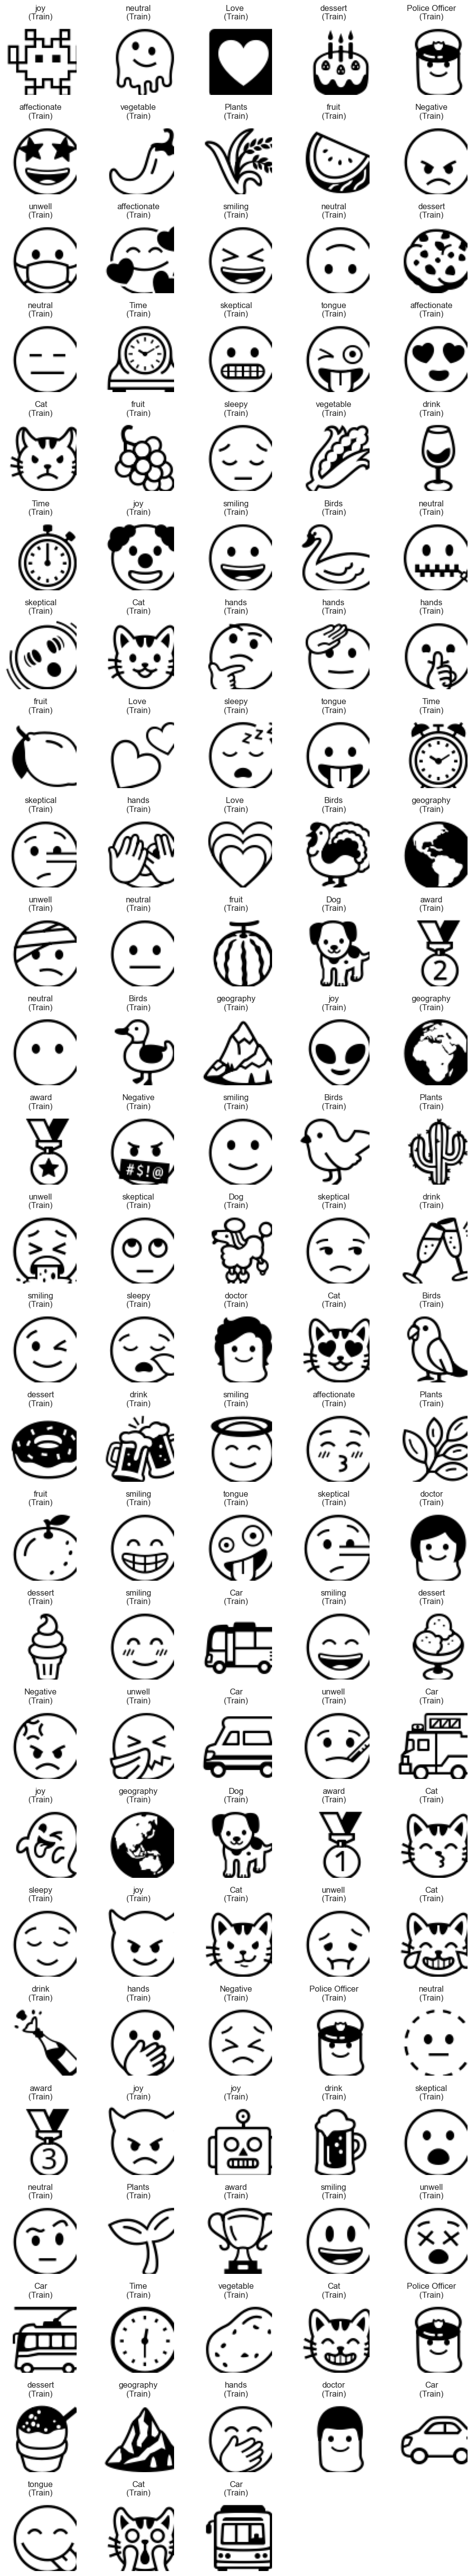

In [322]:
def visualize_images(images, labels, dataset_type, n_cols=5):
    """
    Visualize the image and the label

    - images: image list
    - labels: label list
    - n_cols: # of the images in line
    """
    n_rows = (len(images) + n_cols - 1) // n_cols  # line #
    plt.figure(figsize=(n_cols * 2, n_rows * 2))  # image size
    
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img,cmap='gray')
        plt.title(f"{label}\n({dataset_type})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# call the visualize method
visualize_images(images_train, y_train, 'Train')



### HOG visualize

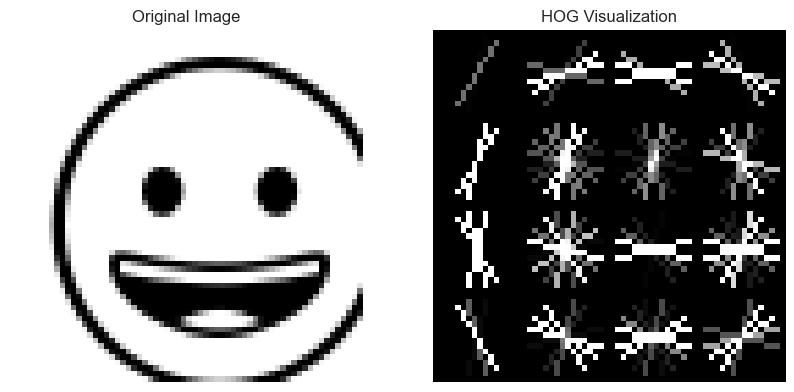

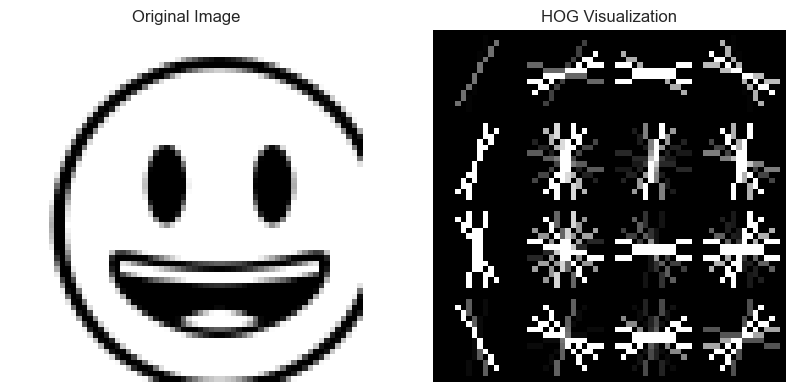

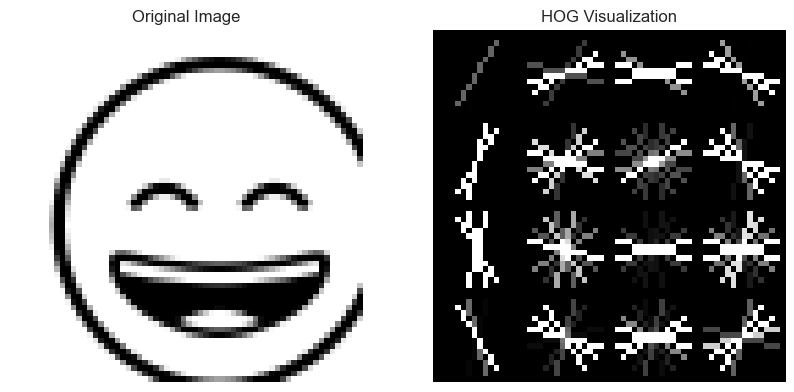

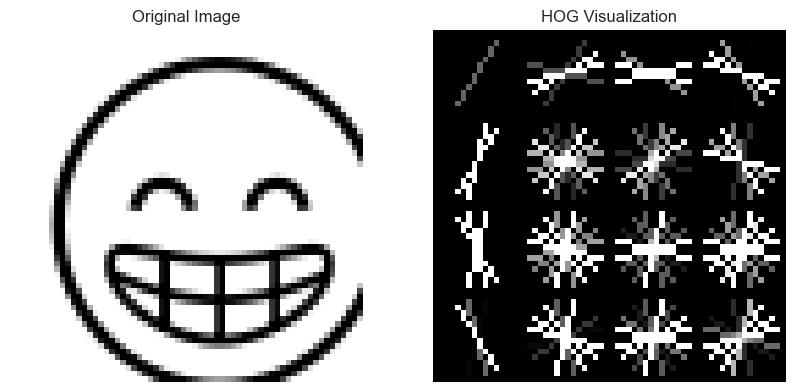

In [323]:


def preprocess_image_for_hog(img):
    # If the image has 3 dimensions but the color channel is not 3 (i.e. it is not a color image), convert to grayscale
    if img.ndim == 3 and img.shape[-1] != 3:
        img = rgb2gray(img)
    # If the image is in color, make sure the color channel is on the last axis
    elif img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    return img



def visualize_hog_features(images):
    """
    visualize the HOG
    

    - images: image list
    """
    for img in images[:4]:
        # calculate the image in list
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        
        # Use exposure.rescale_intensity to adjust the contrast of hog_image
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        plt.figure(figsize=(10, 5))
        
        plt.subplot(121)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(122)
        plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        plt.title('HOG Visualization')
        plt.axis('off')
        
        plt.show()

# Preprocess images before calling visualize_hog_features
images_preprocessed = [preprocess_image_for_hog(img) for img in images]
visualize_hog_features(images_preprocessed)

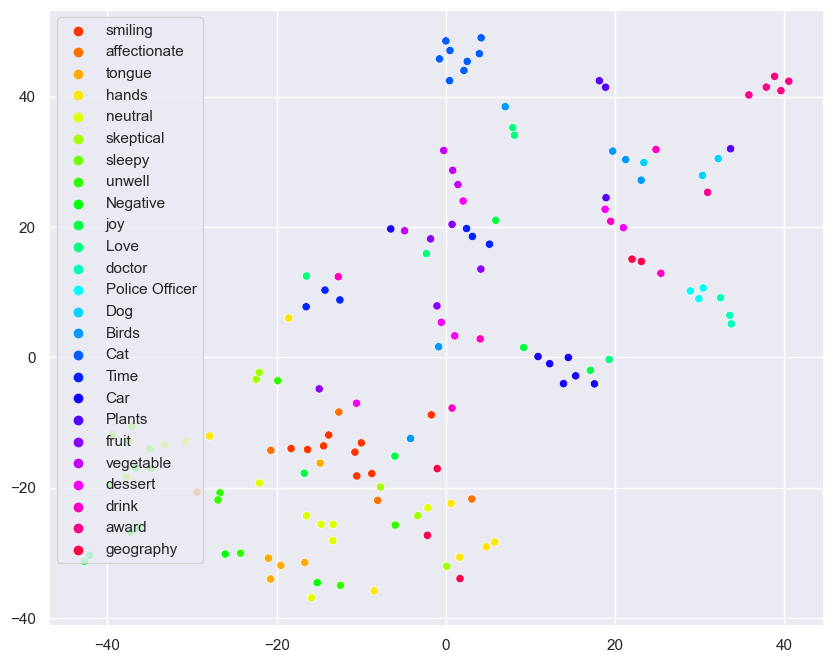

In [331]:
## visualize images in feature space using t-SNE with IDs and Labels for image

sns.set(rc={'figure.figsize':(8,6)})
n_labels = len(np.unique(y))
palette = sns.color_palette("hsv", n_labels)

tsne = TSNE(perplexity=5)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, legend='full', palette=palette)
plt.show()

#for i, labels in enumerate(emojis):
    #plt.annotate(labels, (X_embedded[i,0], X_embedded[i,1]))

### Training SVM model

In [332]:

def train_and_evaluate_svm_with_grid_search(X_train, y_train, X_val, y_val, param_grid=None, cv=5):
    """
    Train and evaluate SVM models using GridSearchCV.


    - param_grid: Hyperparameter grid
    - cv: Cross-validation folds
    
    X: features
    y:labels
    train and validation
    """

    if param_grid is None:
        param_grid = {
            'svc__C': [0.1, 1, 10],
            'svc__kernel': ['rbf', 'linear']
        }
    
    #Create a pipeline for the SVM model
    model = make_pipeline(StandardScaler(), SVC(probability=True))

    #Use GridSearchCV for hyperparameter adjustment
    grid_search = GridSearchCV(model, param_grid, cv=2)
    grid_search.fit(X_train, y_train)

    # Print the best parameters and performance on the cross-validation set
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_)

    # Use the best model to evaluate performance on the test set
    y_pred = grid_search.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy,y_pred


accuracy,y_pred = train_and_evaluate_svm_with_grid_search(X_train, y_train, X_val, y_val)
print(f"Test set accuracy: {accuracy * 100:.2f}%")

Best parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best cross-validation score: 0.4375
Test set accuracy: 53.33%


### K-NN model

In [333]:

def visualize_predictions(images, y_true, y_pred, n_images=5):
    """
    Visualize prediction results.
     - images: image data list.
     - y_true: true tag list.
     - y_pred: list of predicted labels.
     - n_images: Number of images to visualize.
    """
    fig, axes = plt.subplots(nrows=n_images, ncols=2, figsize=(10, n_images * 2))
    for i in range(n_images):
        ax = axes[i, 0]
        ax.imshow(images[i], cmap='gray')  
        ax.set_title(f"Actual: {y_true[i]}")
        ax.axis('off')
        
        ax = axes[i, 1]
        ax.imshow(images[i], cmap='gray')  
        ax.set_title(f"Predicted: {y_pred[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

KNN Model Accuracy with 2 neighbors: 53.33%


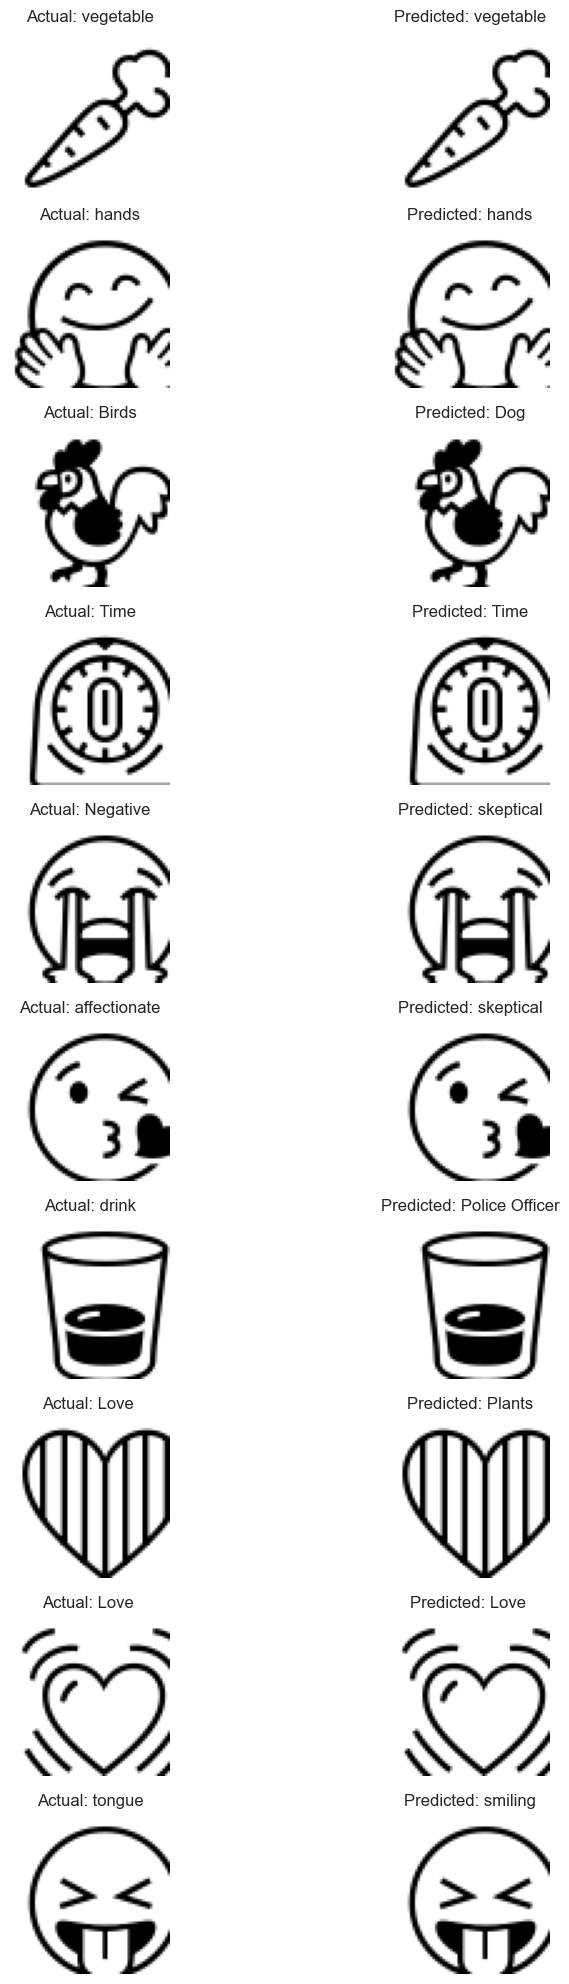

In [334]:
def train_and_evaluate_knn(X_train, y_train, X_val, y_val, n_neighbors=3):
    """
    KNN calculation
    
    - n_neighbors: # neighbors

    reture accurancy
    """

    #Create KNN classifier instance
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # train KNN
    knn.fit(X_train, y_train)
    
    # Predict the results on the validation set
    y_pred = knn.predict(X_val)
    
    # Calculate and return accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy, y_pred

n_neighbors = 2  # K value
accuracy,y_pred = train_and_evaluate_knn(X_train, y_train, X_val, y_val, n_neighbors=n_neighbors)

print(f'KNN Model Accuracy with {n_neighbors} neighbors: {accuracy * 100:.2f}%')
visualize_predictions(images_val, y_val, y_pred, n_images=10)

### Embleated model

In [328]:
def train_and_evaluate_ensemble(X_train, y_train, X_val, y_val, voting='hard'):
    """
    Train and evaluate an ensemble model based on KNN, SVM and random forest.


    - voting: voting strategy,'hard' or  'soft'
    
    return:
    - accuracy
    """
   #Define base learner
    knn = KNeighborsClassifier(n_neighbors=3)
    svm = SVC(probability=True, kernel='rbf', C=1.0)
    rf = RandomForestClassifier(n_estimators=100, random_state=1)

    # Create voting classifier
    voting_clf = VotingClassifier(estimators=[
        ('knn', knn),
        ('svm', svm),
        ('rf', rf)
    ], voting=voting)

    # Train ensemble model
    voting_clf.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = voting_clf.predict(X_val)

    # Calculate and return accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy,y_pred

# Use function
accuracy,y_pred = train_and_evaluate_ensemble(X_train, y_train, X_val, y_val, voting='hard')
print(f'Ensemble Model Accuracy: {accuracy * 100:.2f}%')

Ensemble Model Accuracy: 53.33%


### Test data -- Emoji Kitchen emoji

Test set accuracy: 11.76%


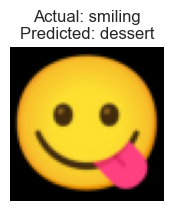

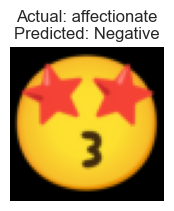

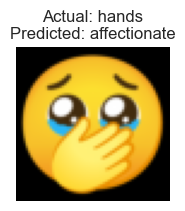

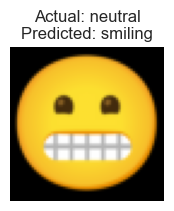

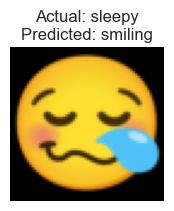

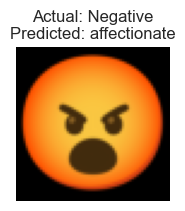

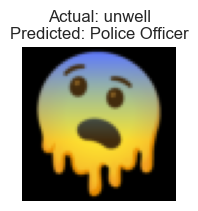

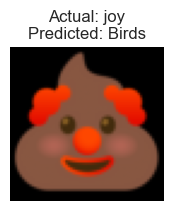

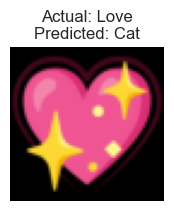

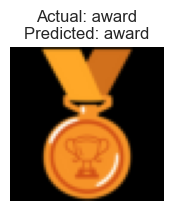

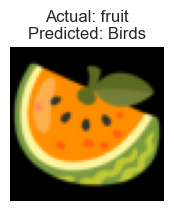

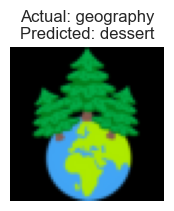

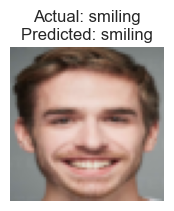

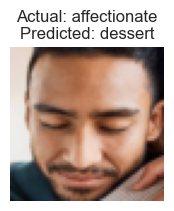

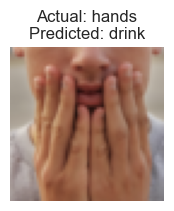

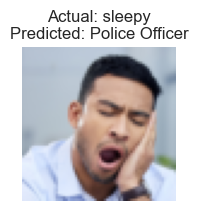

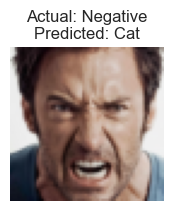

In [306]:
# read CSV
df = pd.read_csv('label.csv')


def load_and_prepare_image(filepath):
    img = imread(filepath)
    img = resize(img, (64, 64))  # ensure images are of consistent size
    if img.shape[-1] == 4:  # For RGBA images, only use RGB three channels
        img = img[..., :3]
    return img



X_test = []
y_test = []


for index, row in df.iterrows():

    img_path = f"{row['filename']}"
    # read image
    img = imread(img_path)
    img = resize(img, (64, 64), anti_aliasing=True, mode='reflect')

    img = (img * 255).astype(np.uint8)
    
    features = get_feat(img)
    X_test.append(features)
    y_test.append(row['label'])

X_test = np.array(X_test)
y_test = np.array(y_test)


# Calculate accuracy
#ccuracy = train_and_evaluate_svm_with_grid_search(X_train, y_train, X_test, y_test)
accuracy,y_pred  = train_and_evaluate_knn(X_train, y_train, X_test, y_test, n_neighbors=2)
#accuracy = train_and_evaluate_ensemble(X_train, y_train, X_test, y_test, voting='hard')

print(f"Test set accuracy: {accuracy * 100:.2f}%")

for index, row in df.iterrows():
    actual_label = row['label']
    predicted_label = y_pred[index]
    image_name = row['filename']
    
    # load image
    img_path = f'./{image_name}'  
    img = load_and_prepare_image(img_path)
    
    # print the image information
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')
    plt.show()